In [2]:
import tensorflow as tf
import os
import cv2
import hashlib
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras import regularizers
from tensorflow.keras.optimizers import Adam
import keras
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pandas as pd


# Importing the data and splitting the folders

In [3]:
#directory for lab
#DATASET_DIR = Path('C:/Users/P2401351/OneDrive - Singapore Polytechnic/DELE FOLDER/CA1 deep learning/Dataset for CA1 part A - AY2526S1')

#directory for personal laptop
DATASET_DIR = Path('C:/Users/Xavier Lee/OneDrive - Singapore Polytechnic/DELE FOLDER/CA1 deep learning/Dataset for CA1 part A - AY2526S1')

# split folders
SPLITS = ['Train', 'Test', 'Validation']

# collect class names from Train split only
class_names = sorted([folder.name for folder in (DATASET_DIR / 'Train').iterdir() if folder.is_dir()])
num_classes = len(class_names)

print(f"Detected {num_classes} classes:\n{class_names}")

Detected 11 classes:
['Bean', 'Bitter_Gourd', 'Brinjal', 'Cabbage', 'Capsicum', 'Cauliflower and Broccoli', 'Cucumber and Bottle_Gourd', 'Potato', 'Pumpkin', 'Radish and Carrot', 'Tomato']


# Exploratory Data Analysis

<Figure size 1400x1000 with 0 Axes>

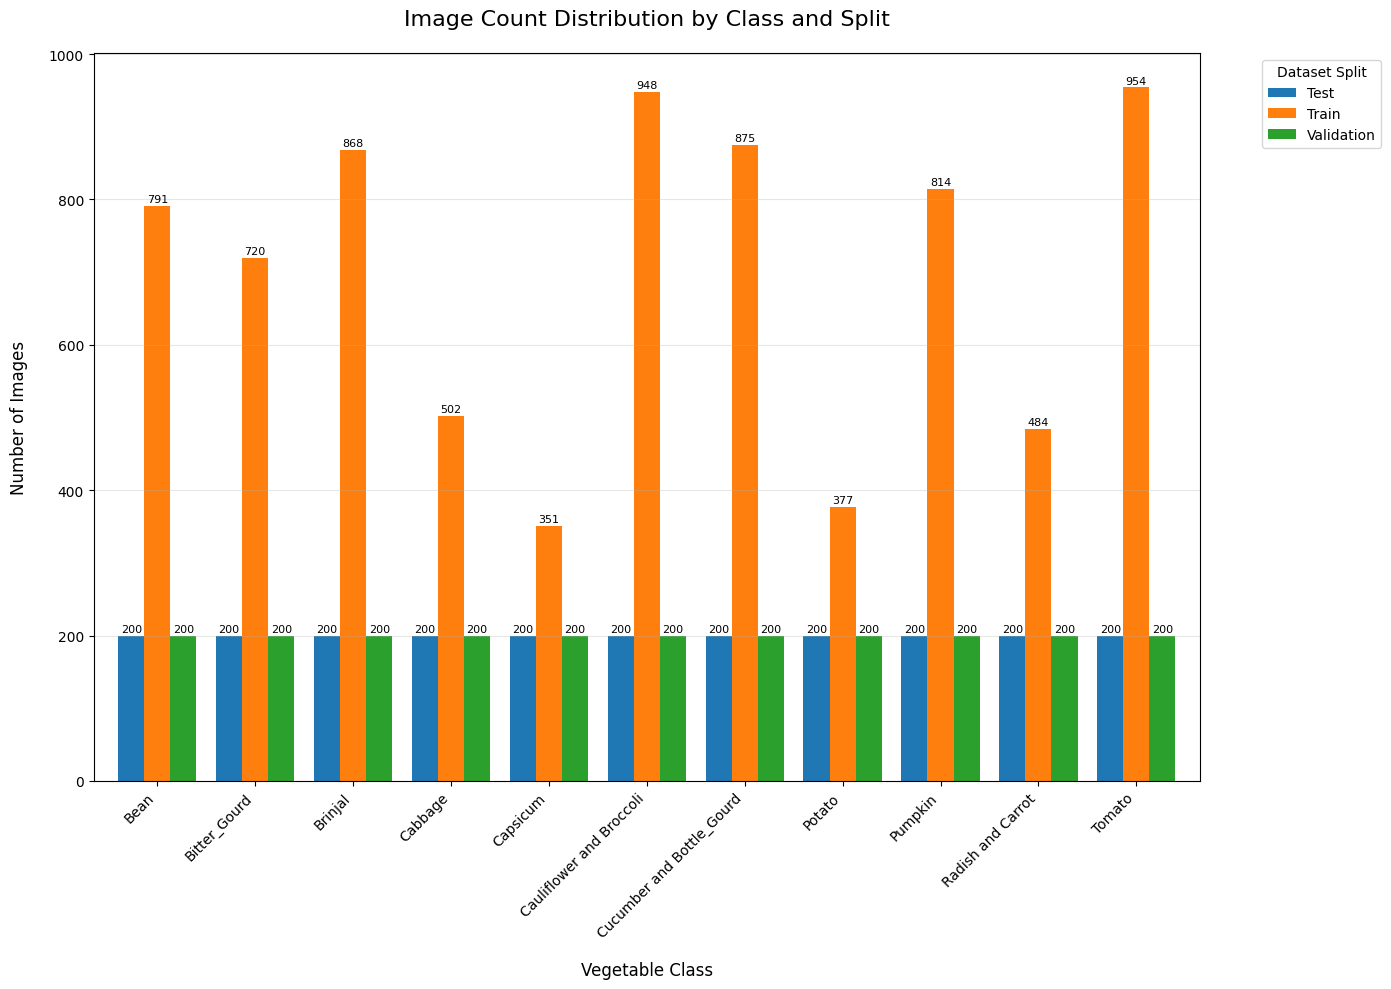


Image Counts by Class and Split:


Split,Test,Train,Validation
Class,,,
Bean,200,791,200
Bitter_Gourd,200,720,200
Brinjal,200,868,200
Cabbage,200,502,200
Capsicum,200,351,200
Cauliflower and Broccoli,200,948,200
Cucumber and Bottle_Gourd,200,875,200
Potato,200,377,200
Pumpkin,200,814,200


In [4]:
# count images per class for each split
image_counts = []

for split in SPLITS:
    split_path = DATASET_DIR / split
    for cls in class_names:
        cls_path = split_path / cls
        count = len(list(cls_path.glob('*.jpg'))) if cls_path.exists() else 0
        image_counts.append({
            'Split': split,
            'Class': cls,
            'Count': count
        })

# create dataFrame
df_counts = pd.DataFrame(image_counts)

# pivot for better visualization
df_pivot = df_counts.pivot(index='Class', columns='Split', values='Count')

# create bar plots
plt.figure(figsize=(14, 10))
ax = df_pivot.plot(kind='bar', width=0.8, figsize=(14, 10))
plt.title('Image Count Distribution by Class and Split', pad=20, fontsize=16)
plt.xlabel('Vegetable Class', labelpad=15, fontsize=12)
plt.ylabel('Number of Images', labelpad=15, fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', alpha=0.3)

# Add value labels
for p in ax.patches:
    if p.get_height() > 0:  # Only label bars with height > 0
        ax.annotate(
            f"{int(p.get_height())}",
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='center',
            xytext=(0, 5),
            textcoords='offset points',
            fontsize=8
        )

# Adjust legend
plt.legend(title='Dataset Split', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# Also display the numerical data in a clean format
print("\nImage Counts by Class and Split:")
display(df_pivot.style.background_gradient(cmap='Blues'))

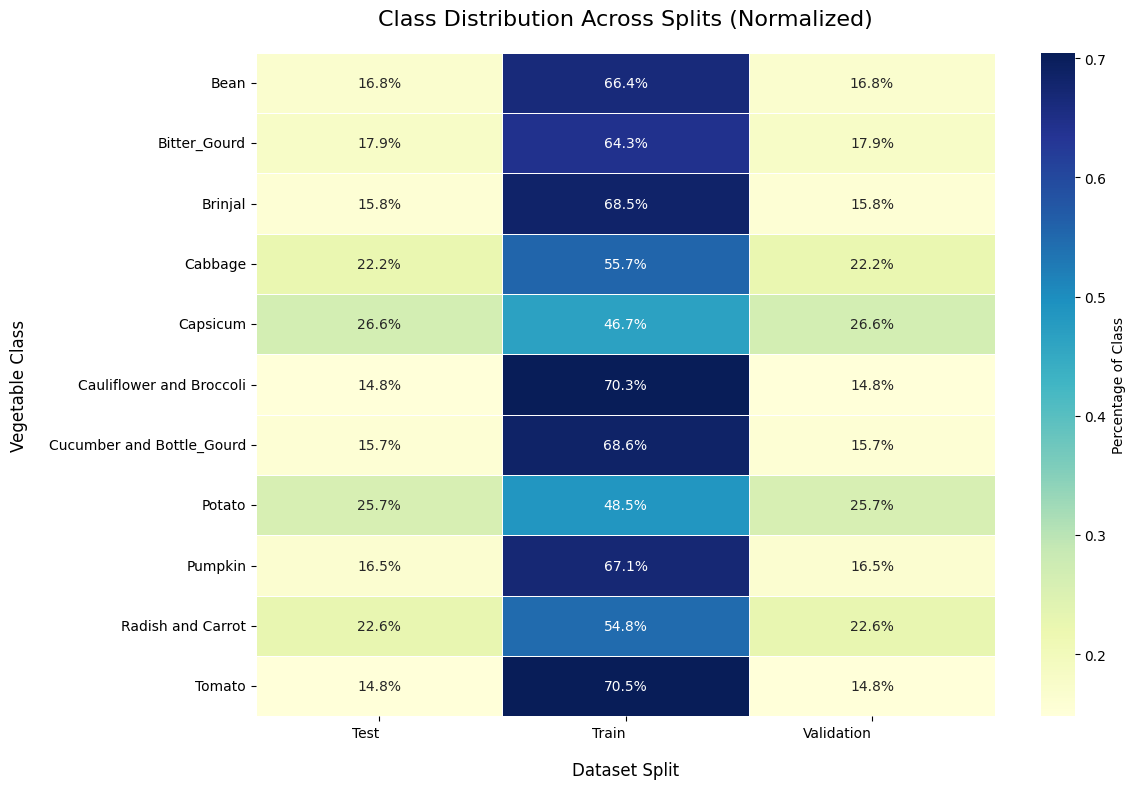

In [5]:
# Heatmap with normalized counts
plt.figure(figsize=(12, 8))
heatmap_data = df_pivot.div(df_pivot.sum(axis=1), axis=0)  # Normalize by class

sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".1%",
    cmap="YlGnBu",
    linewidths=0.5,
    cbar_kws={'label': 'Percentage of Class'}
)

plt.title('Class Distribution Across Splits (Normalized)', pad=20, fontsize=16)
plt.xlabel('Dataset Split', labelpad=15, fontsize=12)
plt.ylabel('Vegetable Class', labelpad=15, fontsize=12)
plt.xticks(ha='right')
plt.tight_layout()
plt.show()

# Conclusion from Data Exploration 
 - The number of validation and test is all the same across all 11 vegetables with 200 images in each folder.
 - the number of train images is very skewed and varies very much across all the vegetables (eg. cauliflower and brocolli vs capsicum) where the difference in the number of train images is almost 3 times!
 - And while I was just scanning over the dataset, there seems to be duplicate images of vegetables found too.


# Data Preprocessing
- We can start by increasing the amount of training data for each class until they all have 954 images by using data augmentation.
  - Scaling
  - Rotating
  - Transformation
  - Flipping
- For the duplicate images we can use a hashing method to drop them

In [6]:
# Duplicate Removal Function
def get_image_hash(image_array):
    image_bytes = image_array.tobytes()
    return hashlib.md5(image_bytes).hexdigest()

def remove_duplicates_from_folder(folder_path, image_size=(23, 23)):
    seen_hashes = set()
    removed_files = []

    for class_folder in os.listdir(folder_path):
        full_class_path = os.path.join(folder_path, class_folder)
        if not os.path.isdir(full_class_path):
            continue

        for filename in os.listdir(full_class_path):
            file_path = os.path.join(full_class_path, filename)
            img = cv2.imread(file_path)  # Read in color
            if img is None:
                continue
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
            resized = cv2.resize(gray, image_size)
            img_hash = get_image_hash(resized)

            if img_hash in seen_hashes:
                os.remove(file_path)
                removed_files.append(file_path)
            else:
                seen_hashes.add(img_hash)

    print(f"Removed {len(removed_files)} duplicate images from {folder_path}.")
    return removed_files
    
# There are  duplicate pictures and i have decided to drop the duplicate images because it accounts
# for a very small percentage of the daaset and will not skew it by much.
# Apply Duplicate Removal to All Splits 
for split in SPLITS:
    split_path = DATASET_DIR / split
    remove_duplicates_from_folder(split_path, image_size=(23, 23))


Removed 0 duplicate images from C:\Users\Xavier Lee\OneDrive - Singapore Polytechnic\DELE FOLDER\CA1 deep learning\Dataset for CA1 part A - AY2526S1\Train.
Removed 0 duplicate images from C:\Users\Xavier Lee\OneDrive - Singapore Polytechnic\DELE FOLDER\CA1 deep learning\Dataset for CA1 part A - AY2526S1\Test.
Removed 0 duplicate images from C:\Users\Xavier Lee\OneDrive - Singapore Polytechnic\DELE FOLDER\CA1 deep learning\Dataset for CA1 part A - AY2526S1\Validation.


In [7]:
#  Data Augmentation to Balance Classes in Train Split 
def augment_image_rgb(image):
    augmented = []
    h, w = image.shape[:2]

    # Rotation
    angle = random.choice([90, 180, 270])
    M_rot = cv2.getRotationMatrix2D((w//2, h//2), angle, 1)
    augmented.append(cv2.warpAffine(image, M_rot, (w, h)))

    # Flipping
    augmented.append(cv2.flip(image, 0))  # vertical
    augmented.append(cv2.flip(image, 1))  # horizontal

    # Translation
    M_trans = np.float32([[1, 0, 5], [0, 1, 5]])
    translated = cv2.warpAffine(image, M_trans, (w, h))
    augmented.append(translated)

    return augmented

def balance_class_images(train_dir, target_count=954):
    for class_name in os.listdir(train_dir):
        class_path = os.path.join(train_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        images = os.listdir(class_path)
        current_count = len(images)
        if current_count >= target_count:
            continue

        print(f"Augmenting class '{class_name}' from {current_count} to {target_count} images...")
        while len(os.listdir(class_path)) < target_count:
            img_name = random.choice(images)
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            if img is None:
                continue
            aug_imgs = augment_image_rgb(img)

            for aug_img in aug_imgs:
                if len(os.listdir(class_path)) >= target_count:
                    break
                new_filename = f"aug_{random.randint(10000,99999)}.png"
                cv2.imwrite(os.path.join(class_path, new_filename), aug_img)

# Apply augmentation only to Train folder
balance_class_images(str(DATASET_DIR / 'Train'), target_count=954)

In [8]:
# reimport the new augmented dataset
#directory for lab
#DATASET_DIR = Path('C:/Users/P2401351/OneDrive - Singapore Polytechnic/DELE FOLDER/CA1 deep learning/Dataset for CA1 part A - AY2526S1')

#directory for personal laptop
DATASET_DIR = Path('C:/Users/Xavier Lee/OneDrive - Singapore Polytechnic/DELE FOLDER/CA1 deep learning/Dataset for CA1 part A - AY2526S1')


<Figure size 1400x1000 with 0 Axes>

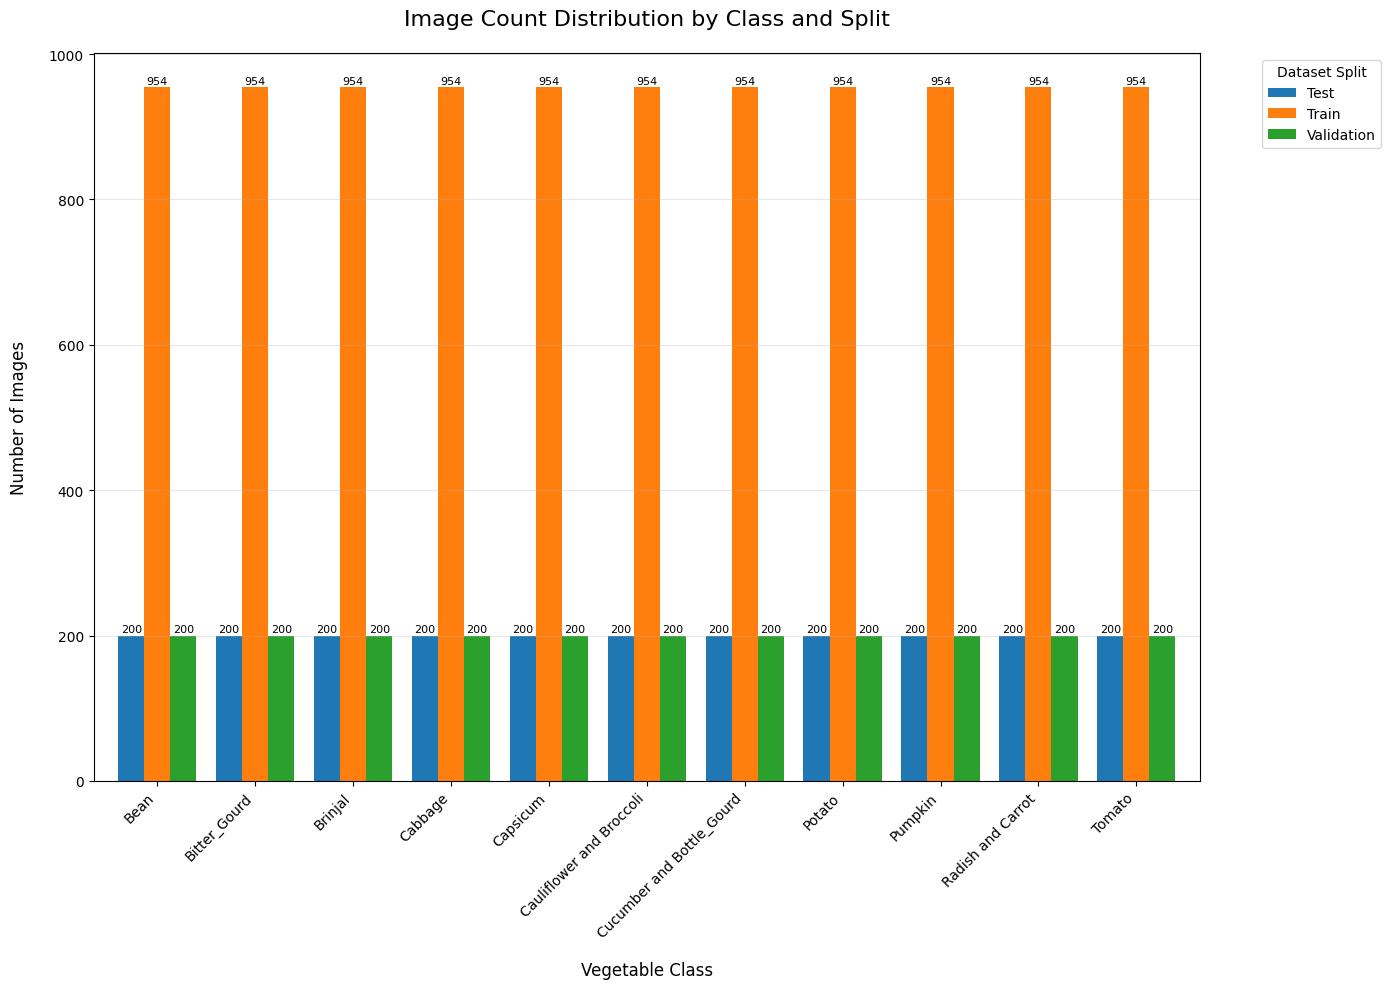

In [9]:
# count images per class for each split after augmentation
image_counts = []

for split in SPLITS:
    split_path = DATASET_DIR / split
    for cls in class_names:
        cls_path = split_path / cls
        count = len(list(cls_path.glob('*.jpg'))) + len(list(cls_path.glob('*.png')))
        image_counts.append({
            'Split': split,
            'Class': cls,
            'Count': count
        })

# create dataFrame
df_counts = pd.DataFrame(image_counts)

# pivot for better visualization
df_pivot = df_counts.pivot(index='Class', columns='Split', values='Count')

# create bar plots
plt.figure(figsize=(14, 10))
ax = df_pivot.plot(kind='bar', width=0.8, figsize=(14, 10))
plt.title('Image Count Distribution by Class and Split', pad=20, fontsize=16)
plt.xlabel('Vegetable Class', labelpad=15, fontsize=12)
plt.ylabel('Number of Images', labelpad=15, fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', alpha=0.3)

# Add value labels
for p in ax.patches:
    if p.get_height() > 0:  # Only label bars with height > 0
        ax.annotate(
            f"{int(p.get_height())}",
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='center',
            xytext=(0, 5),
            textcoords='offset points',
            fontsize=8
        )

# Adjust legend
plt.legend(title='Dataset Split', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

### now that we have "cleaned" our dataset, we can see that the dataset is alot more balanced now with all the 11 classes of vegetables having 954 images each. and there is no more duplicate images

# Training the 23 x 23 model

## Loading the data to IMG_SIZE_A 

In [14]:
# data Loading and Preprocessing for 23 by 23 
IMG_SIZE_A = (23, 23)

In [21]:
# load training data
train_images_A = []
train_labels_A = []
train_path_A = DATASET_DIR / 'Train'
for i, class_name in enumerate(class_names):
    class_path = train_path_A / class_name
    if class_path.exists():
        for image_path in class_path.glob('*'):
            if image_path.suffix.lower() not in ['.jpg', '.jpeg', '.png']:
                continue
            image = tf.io.read_file(str(image_path))
            image = tf.image.decode_image(image, channels=3)
            image = tf.image.rgb_to_grayscale(image)
            image = tf.image.resize(image, IMG_SIZE_A)
            image = tf.cast(image, tf.float32) / 255.0
            train_images_A.append(image)
            train_labels_A.append(i)
train_images_A = np.array(train_images_A)
train_labels_A = np.array(train_labels_A)


In [15]:
# load validation data
validation_images_A = []
validation_labels_A = []
validation_path_A = DATASET_DIR / 'Validation'
for i, class_name in enumerate(class_names):
    class_path = validation_path_A / class_name
    if class_path.exists():
        for image_path in class_path.glob('*'):
            if image_path.suffix.lower() not in ['.jpg', '.jpeg', '.png']:
                continue            
            image = tf.io.read_file(str(image_path))
            image = tf.image.decode_jpeg(image, channels=3)
            image = tf.image.rgb_to_grayscale(image)
            image = tf.image.resize(image, IMG_SIZE_A)
            image = tf.cast(image, tf.float32) / 255.0
            validation_images_A.append(image)
            validation_labels_A.append(i)
validation_images_A = np.array(validation_images_A)
validation_labels_A = np.array(validation_labels_A)

In [16]:
# load test data
test_images_A = []
test_labels_A = []
test_path_A = DATASET_DIR / 'Test'
for i, class_name in enumerate(class_names):
    class_path = test_path_A / class_name
    if class_path.exists():
        for image_path in class_path.glob('*'):
            if image_path.suffix.lower() not in ['.jpg', '.jpeg', '.png']:
                continue           
            image = tf.io.read_file(str(image_path))
            image = tf.image.decode_jpeg(image, channels=3)
            image = tf.image.rgb_to_grayscale(image)
            image = tf.image.resize(image, IMG_SIZE_A)
            image = tf.cast(image, tf.float32) / 255.0
            test_images_A.append(image)
            test_labels_A.append(i)
test_images_A = np.array(test_images_A)
test_labels_A = np.array(test_labels_A)

## display the images that have been grayscaled and reduced to 23 by 23 pixels
#### what can we tell after reducing and grayscaling the images to 23 by 23 pixels?
- the images are extremely blurry and some vegetables like bittergourd do not look like anything mortally existable.
- meaning if we make our model too complex, we will run into issues where it will overanalyze and unable to generalise well when given a test set because of overfitting, leading to horrendous accuracies and loss.


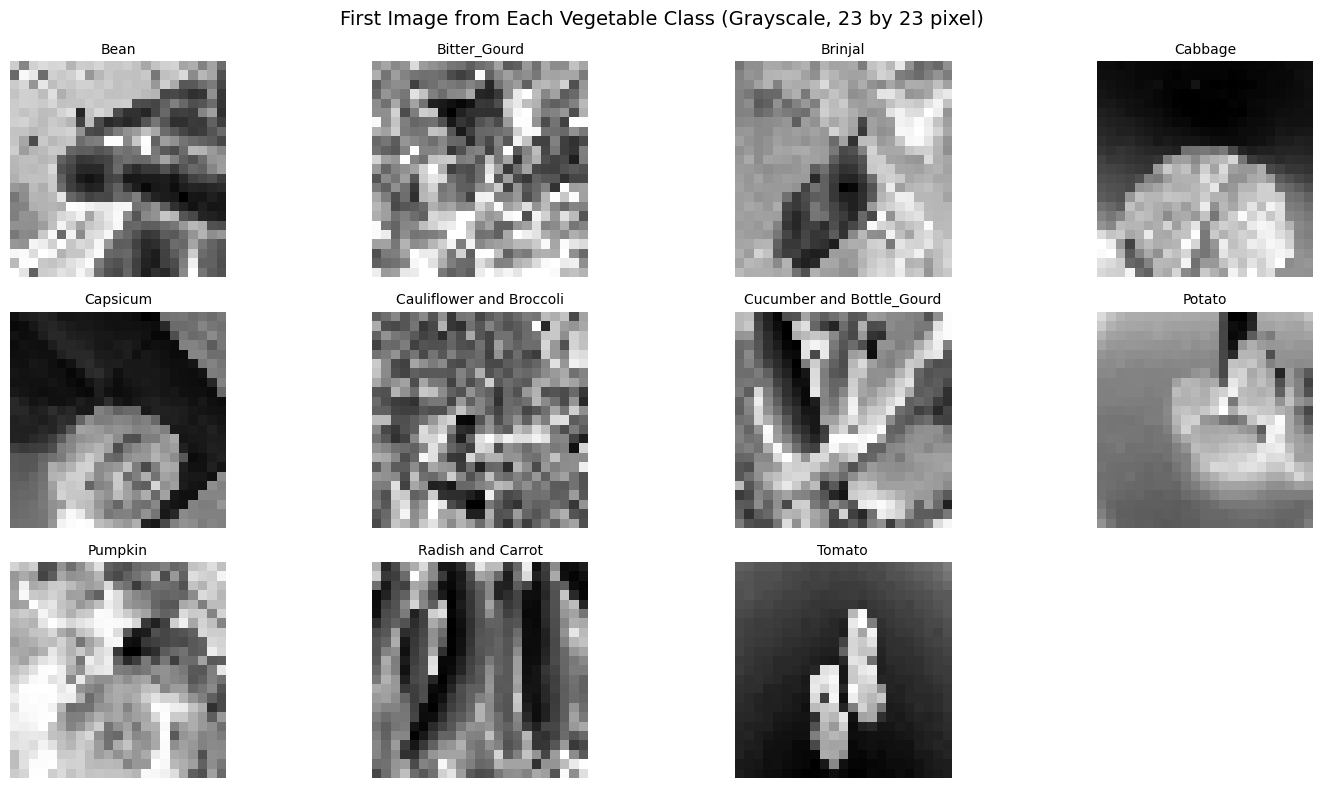

In [13]:
plt.figure(figsize=(15, 8))
for i, class_name in enumerate(class_names):
    # Find first image belonging to this class
    idx = np.where(train_labels_A == i)[0][0]
    img = train_images_A[idx].squeeze()
    
    plt.subplot(3, (len(class_names)+2)//3, i+1)
    plt.imshow(img, cmap=plt.cm.binary)
    plt.title(class_name, fontsize=10)
    plt.axis('off')

plt.suptitle("First Image from Each Vegetable Class (Grayscale, 23 by 23 pixel)", fontsize=14)
plt.tight_layout()
plt.show()


## Initial model building for 23 by 23

In [14]:
# build initial model
model_A = keras.Sequential([
    keras.Input(shape=(23, 23, 1)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])


In [15]:
# model compiling
model_A.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
# model training
history_A = model_A.fit(train_images_A, train_labels_A, epochs=20, validation_data=(validation_images_A, validation_labels_A))


Epoch 1/20
328/328 [==============================] - 24s 18ms/step - loss: 2.1146 - accuracy: 0.2626 - val_loss: 1.8130 - val_accuracy: 0.3918
Epoch 2/20
328/328 [==============================] - 5s 15ms/step - loss: 1.7199 - accuracy: 0.4252 - val_loss: 1.5721 - val_accuracy: 0.4718
Epoch 3/20
328/328 [==============================] - 5s 15ms/step - loss: 1.4640 - accuracy: 0.5093 - val_loss: 1.2750 - val_accuracy: 0.5741
Epoch 4/20
328/328 [==============================] - 5s 15ms/step - loss: 1.2963 - accuracy: 0.5656 - val_loss: 1.2036 - val_accuracy: 0.5964
Epoch 5/20
328/328 [==============================] - 5s 15ms/step - loss: 1.1535 - accuracy: 0.6072 - val_loss: 1.0621 - val_accuracy: 0.6395
Epoch 6/20
328/328 [==============================] - 5s 15ms/step - loss: 1.0454 - accuracy: 0.6523 - val_loss: 1.1307 - val_accuracy: 0.6082
Epoch 7/20
328/328 [==============================] - 5s 16ms/step - loss: 0.9488 - accuracy: 0.6866 - val_loss: 1.0248 - val_accuracy: 0.655

Test Loss (23x23): 0.7170
Test Accuracy (23x23): 0.8014
69/69 [==============================] - 1s 6ms/step

Classification Report (23x23):
                           precision    recall  f1-score   support

                     Bean       0.80      0.82      0.81       200
             Bitter_Gourd       0.85      0.85      0.85       200
                  Brinjal       0.77      0.87      0.82       200
                  Cabbage       0.91      0.67      0.77       200
                 Capsicum       0.74      0.88      0.81       200
 Cauliflower and Broccoli       0.75      0.66      0.70       200
Cucumber and Bottle_Gourd       0.87      0.82      0.85       200
                   Potato       0.87      0.80      0.83       200
                  Pumpkin       0.78      0.89      0.83       200
        Radish and Carrot       0.84      0.74      0.79       200
                   Tomato       0.70      0.82      0.76       200

                 accuracy                           0

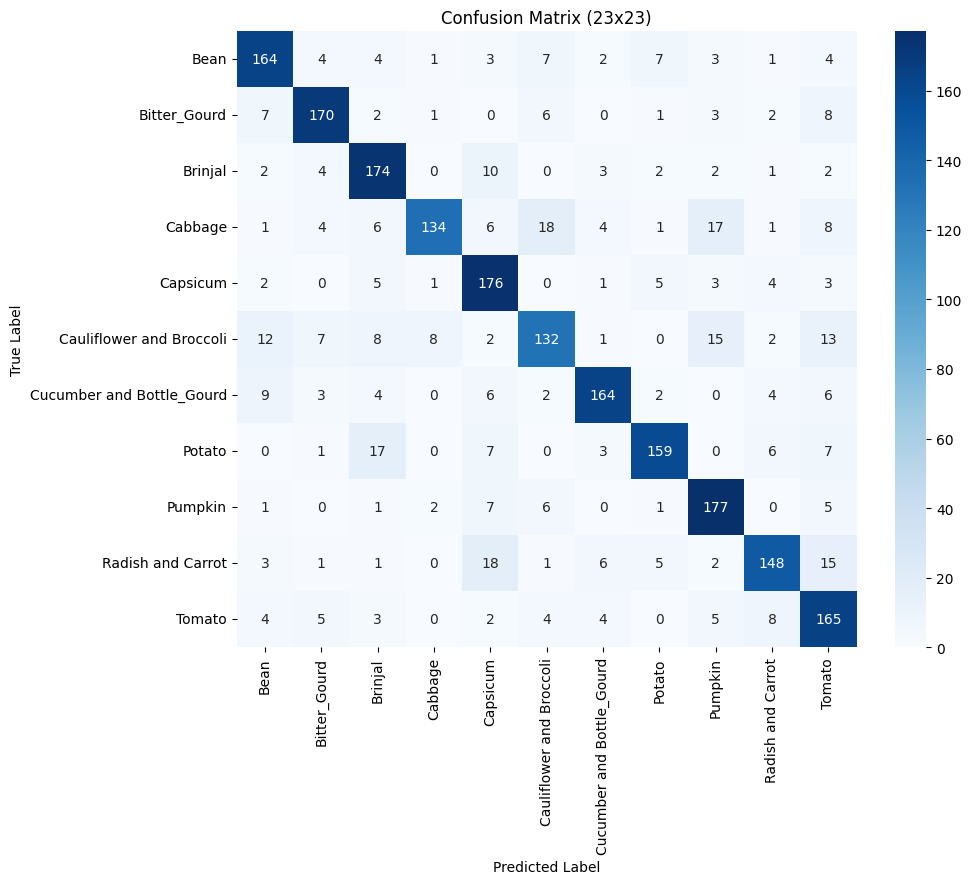

In [17]:
# model evaluation
loss_A, accuracy_A = model_A.evaluate(test_images_A, test_labels_A, verbose=0)
print(f"Test Loss (23x23): {loss_A:.4f}")
print(f"Test Accuracy (23x23): {accuracy_A:.4f}")

predictions_A = model_A.predict(test_images_A)
predicted_labels_A = np.argmax(predictions_A, axis=1)

print("\nClassification Report (23x23):")
print(classification_report(test_labels_A, predicted_labels_A, target_names=class_names))

cm_A = confusion_matrix(test_labels_A, predicted_labels_A)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_A, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (23x23)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

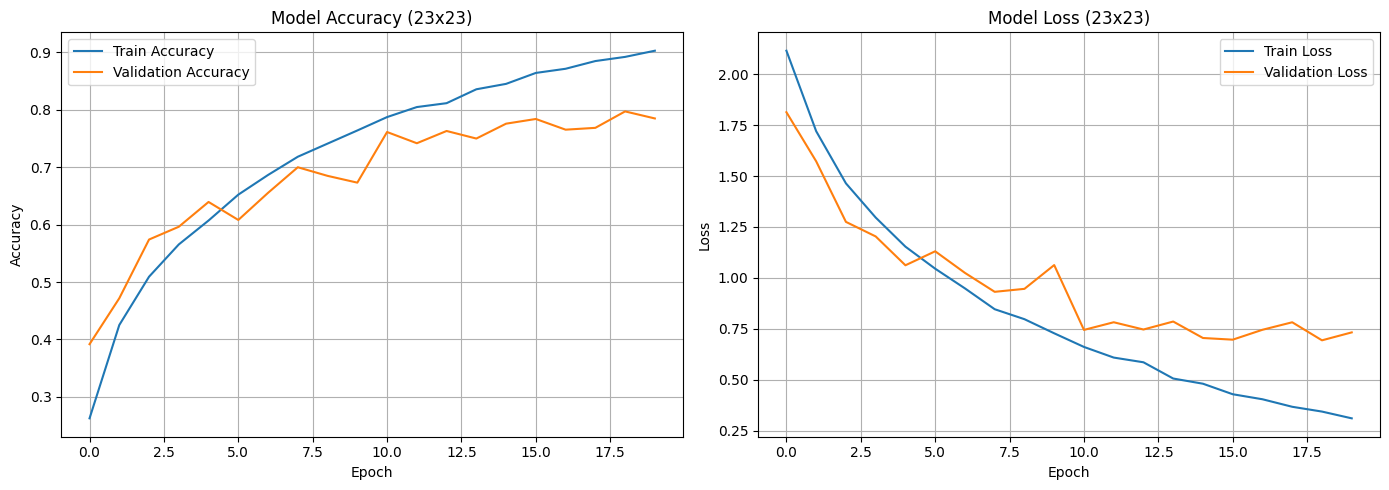

In [36]:
plt.figure(figsize=(14, 5))

# Accuracy history plot
plt.subplot(1, 2, 1)
plt.plot(history_A.history['accuracy'], label='Train Accuracy')
plt.plot(history_A.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy (23x23)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss history plot
plt.subplot(1, 2, 2)
plt.plot(history_A.history['loss'], label='Train Loss')
plt.plot(history_A.history['val_loss'], label='Validation Loss')
plt.title('Model Loss (23x23)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### What can we tell from the basic model building?
- It does perform quite well even before hyperparameter tuning based on our test accuracy. Means that we are on the right track based on our models architecture. Our training history graph provides us on some insight on whether we are underfitting or overfitting and it looks like we are overfitting, meaning we should make our model less complex.

## Hyperparamter tuning for 23 by 23

In [23]:
# define hyperparameters
conv_filters = [32, 64]  
dense_units = [32, 64, 128] 
dropouts = [0.3, 0.4]   
batch_sizes = [32, 64]
learning_rates = [1e-3, 1e-4] 

best_val_acc_23 = 0.0
best_model_23 = None
best_config_23 = {}
all_histories = []

In [47]:
for f in conv_filters:
    for d in dense_units:
        for do in dropouts:
            for bs in batch_sizes:
                for lr in learning_rates: 
                    print(f'\nConv_filters: {f}, Dense_units: {d}, Dropout: {do}, Batch_size: {bs}, Learning Rate: {lr}')

                    model_23 = keras.Sequential([
                        keras.Input(shape=(23, 23, 1)),
                        layers.Conv2D(f, (3, 3), activation='relu', padding='same', kernel_regularizer='l2'), 
                        layers.BatchNormalization(),
                        layers.MaxPooling2D((2, 2)),
                        layers.Dropout(do),
                        layers.Conv2D(f * 2, (3, 3), activation='relu', padding='same', kernel_regularizer='l2'), 
                        layers.BatchNormalization(),
                        layers.MaxPooling2D((2, 2)),
                        layers.Dropout(do),
                        layers.Conv2D(f * 4, (3, 3), activation='relu', padding='same', kernel_regularizer='l2'), 
                        layers.BatchNormalization(),
                        layers.GlobalAveragePooling2D(),
                        layers.Dense(d, activation='relu', kernel_regularizer='l2'),
                        layers.Dropout(do),
                        layers.Dense(num_classes, activation='softmax')
                    ])

                    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
                    model_23.compile(optimizer=optimizer,
                                  loss='sparse_categorical_crossentropy',
                                  metrics=['accuracy'])
                    
                    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True) 
                    history_23 = model_23.fit(train_images_A, train_labels_A, epochs=20, batch_size=bs, validation_data=(validation_images_A, validation_labels_A), verbose=0, callbacks=[early_stopping])
                    all_histories.append(history_23.history)

                    val_acc = history_23.history['val_accuracy'][-1]
                    print(f"Validation accuracy: {val_acc:.4f}\n")

                    if val_acc > best_val_acc_23:
                        best_val_acc_23 = val_acc
                        best_model_23 = model_23
                        best_config_23 = {'conv_filters': f, 'dense_units': d, 'dropout': do, 'batch_size': bs, 'learning_rate': lr} 

print("\nBest Validation Accuracy:", best_val_acc_23)
print("Best Configurations:", best_config_23)


Conv_filters: 32, Dense_units: 32, Dropout: 0.3, Batch_size: 32, Learning Rate: 0.001
Validation accuracy: 0.6118


Conv_filters: 32, Dense_units: 32, Dropout: 0.3, Batch_size: 32, Learning Rate: 0.0001
Validation accuracy: 0.7577


Conv_filters: 32, Dense_units: 32, Dropout: 0.3, Batch_size: 64, Learning Rate: 0.001
Validation accuracy: 0.6736


Conv_filters: 32, Dense_units: 32, Dropout: 0.3, Batch_size: 64, Learning Rate: 0.0001
Validation accuracy: 0.7186


Conv_filters: 32, Dense_units: 32, Dropout: 0.4, Batch_size: 32, Learning Rate: 0.001
Validation accuracy: 0.4677


Conv_filters: 32, Dense_units: 32, Dropout: 0.4, Batch_size: 32, Learning Rate: 0.0001
Validation accuracy: 0.5609


Conv_filters: 32, Dense_units: 32, Dropout: 0.4, Batch_size: 64, Learning Rate: 0.001
Validation accuracy: 0.6855


Conv_filters: 32, Dense_units: 32, Dropout: 0.4, Batch_size: 64, Learning Rate: 0.0001
Validation accuracy: 0.5968


Conv_filters: 32, Dense_units: 64, Dropout: 0.3, Batch_size: 32, Le

## Observations during hyperparams tuning (23x23):
- after tuning, we have improved significantly in test accuracy
- our training history is extremely jumpy and does not generalize well,indicating overfitting is our main problem
- even after making huge dropouts we still have not solved our overfitting issue.
- after removing batchnormalization, we have solved our issue of overfitting with the loss history going down steadily and exponentially per epoch but it has made our model extremely inaccurate.

## Manual tuning for 23 by 23

In [101]:
# define hyperparameters
best_val_acc_23 = 0.0
best_model_23 = None
best_config_23 = {}
all_histories = []

In [102]:
model_23 = keras.Sequential([
    keras.Input(shape=(23, 23, 1)),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer='l2'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer='l2'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer='l2'),
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),
    layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model_23.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Implement Early Stopping
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=5,verbose=1, min_lr=1e-7)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True) 
history_23 = model_23.fit(
    train_images_A, train_labels_A,
    epochs=100,
    batch_size=32,
    validation_data=(validation_images_A, validation_labels_A),
    verbose=0,
    callbacks=[early_stopping, reduce_lr]
)
all_histories.append(history_23.history)

val_acc = history_23.history['val_accuracy'][-1]
print(f"Validation accuracy: {val_acc:.4f}\n")

if val_acc > best_val_acc_23:
    best_val_acc_23 = val_acc
    best_model_23 = model_23


print("\nBest Validation Accuracy:", best_val_acc_23)
print("Best Configurations:", best_config_23)


Epoch 78: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
Validation accuracy: 0.8695


Best Validation Accuracy: 0.8695454597473145
Best Configurations: {}


Test Loss (23x23): 0.4653
Test Accuracy (23x23): 0.8982
69/69 [==============================] - 1s 7ms/step

Classification Report (23x23 - Best Model before random erasing):
                           precision    recall  f1-score   support

                     Bean       0.86      0.92      0.89       200
             Bitter_Gourd       0.87      0.93      0.90       200
                  Brinjal       0.92      0.95      0.93       200
                  Cabbage       0.92      0.84      0.88       200
                 Capsicum       0.95      0.92      0.94       200
 Cauliflower and Broccoli       0.81      0.81      0.81       200
Cucumber and Bottle_Gourd       0.91      0.93      0.92       200
                   Potato       0.92      0.89      0.91       200
                  Pumpkin       0.92      0.90      0.91       200
        Radish and Carrot       0.91      0.96      0.94       200
                   Tomato       0.89      0.83      0.86       200

                 a

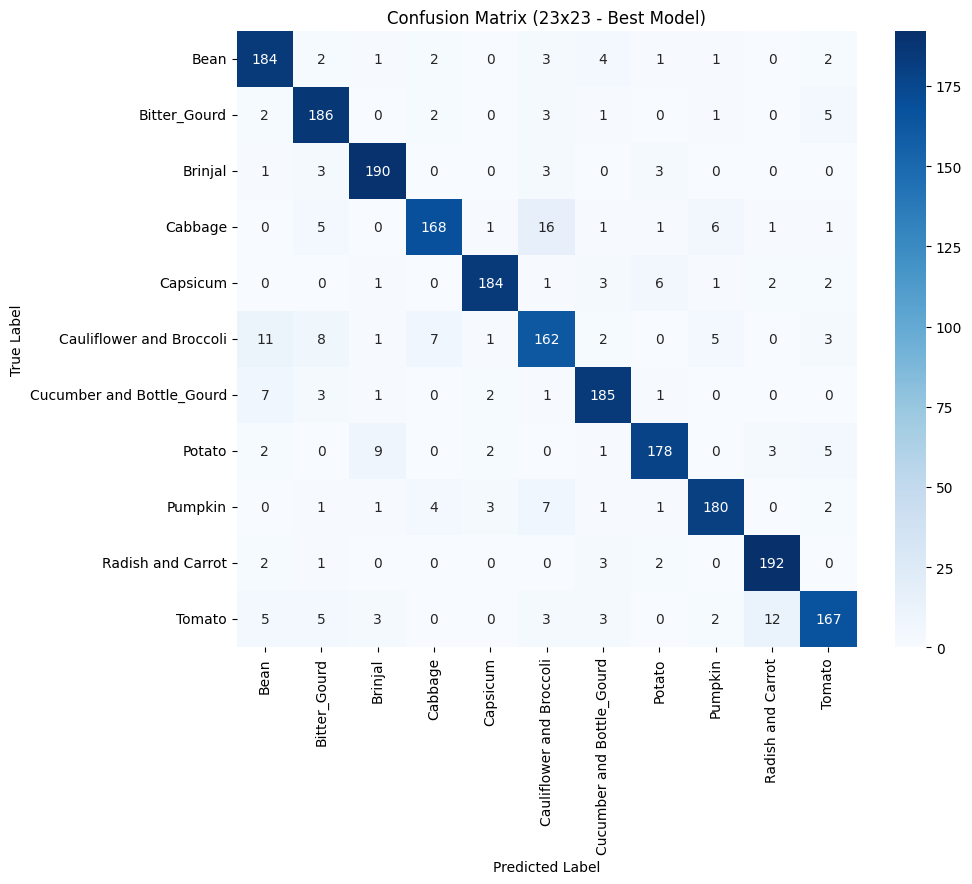

In [105]:
# Model Evaluation (23x23 Grayscale - Best Model before random erasing)
loss_A, accuracy_A = best_model_23.evaluate(test_images_A, test_labels_A, verbose=0)
print(f"Test Loss (23x23): {loss_A:.4f}")
print(f"Test Accuracy (23x23): {accuracy_A:.4f}")

predictions_A = best_model_23.predict(test_images_A)
predicted_labels_A = np.argmax(predictions_A, axis=1)


print("\nClassification Report (23x23 - Best Model before random erasing):")
print(classification_report(test_labels_A, predicted_labels_A, target_names=class_names))

cm_A = confusion_matrix(test_labels_A, predicted_labels_A)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_A, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (23x23 - Best Model)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

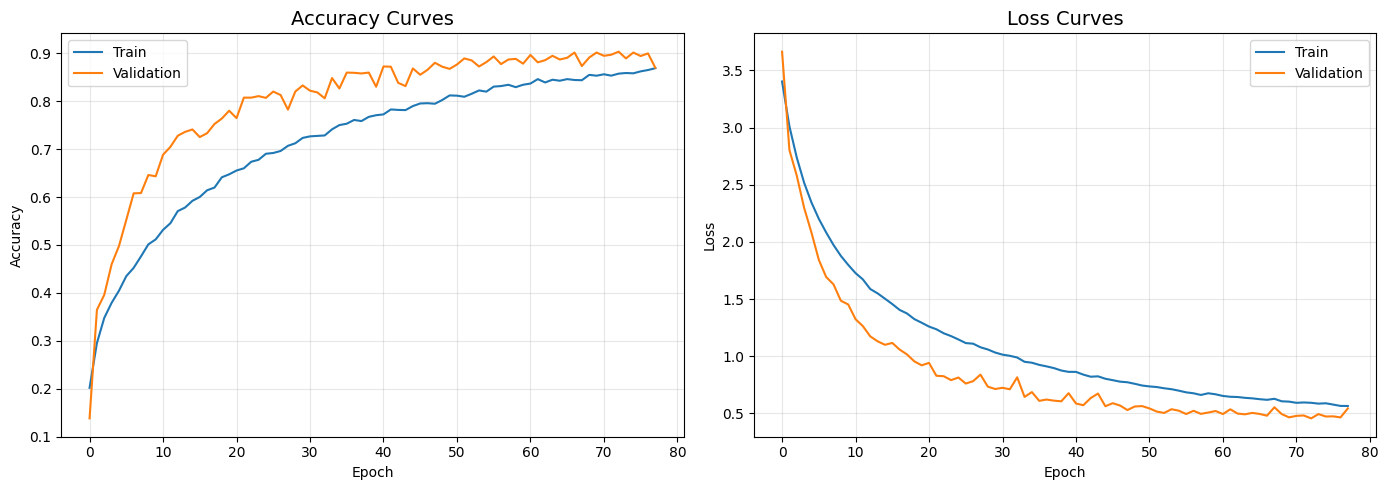

In [106]:
# plot training history
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history_23.history['accuracy'], label='Train')
plt.plot(history_23.history['val_accuracy'], label='Validation')
plt.title('Accuracy Curves', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history_23.history['loss'], label='Train')
plt.plot(history_23.history['val_loss'], label='Validation')
plt.title('Loss Curves', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## What can we do about the anomolies that lie in the confusion matrix?
- we can apply random erasing forcing our model to learn more robust features from the remaining visible parts.
- using this function, we can easily solve why are model is predicting some vegetables wrong consistently.

In [17]:
# Data Augmentation Function (Random Erasing)
def random_erasing(image, sl=0.02, sh=0.4, r1=0.3, r2=3.3, p=0.5):
    if tf.random.uniform([]) < p:
        img_h, img_w, img_c = image.shape
        img_area = tf.cast(img_h * img_w, tf.float32)

        # Calculate erase area bounds
        erase_area_low = tf.cast(sl * img_area, tf.int32)
        erase_area_high = tf.cast(sh * img_area, tf.int32)
        erase_area_low = tf.maximum(erase_area_low, 1) # Ensure min area is at least 1 pixel

        # Randomly choose area and aspect ratio for the erasing block
        erase_area = tf.random.uniform([], minval=tf.cast(erase_area_low, tf.float32), maxval=tf.cast(erase_area_high, tf.float32))
        aspect_ratio = tf.random.uniform([], minval=r1, maxval=r2)
        
        # Calculate height and width of erasing block
        h_erase = tf.cast(tf.round(tf.sqrt(erase_area / aspect_ratio)), tf.int32)
        w_erase = tf.cast(tf.round(tf.sqrt(erase_area * aspect_ratio)), tf.int32)

        # Clip dimensions to image bounds
        h_erase = tf.minimum(h_erase, img_h)
        w_erase = tf.minimum(w_erase, img_w)
        
        # Randomly choose top-left corner
        # Ensure x and y don't go out of bounds
        x = tf.random.uniform([], minval=0, maxval=tf.maximum(1, img_w - w_erase), dtype=tf.int32)
        y = tf.random.uniform([], minval=0, maxval=tf.maximum(1, img_h - h_erase), dtype=tf.int32)

        # Create the erasing block (random values)
        erasing_value = tf.random.uniform(image[y:y+h_erase, x:x+w_erase, :].shape, minval=0.0, maxval=1.0)
        
        # Create a mask for the erased region
        indices_x = tf.range(x, x + w_erase)
        indices_y = tf.range(y, y + h_erase)
        
        # Create a 2D meshgrid of coordinates within the erased region
        grid_x, grid_y = tf.meshgrid(indices_x, indices_y)
        
        # Stack coordinates to form (N, 2) tensor of indices
        indices = tf.stack([tf.reshape(grid_y, [-1]), tf.reshape(grid_x, [-1])], axis=-1)
        
        # Replace the region with erasing_value
        # For grayscale, it's typically (H, W, 1)
        # Using tf.tensor_scatter_nd_update requires indices to be (num_updates, rank)
        # and updates to be (num_updates, shape_of_element_at_index)
        
        # Manual approach for replacing values using slicing, more readable and safer
        erased_image = tf.identity(image) # Create a copy to modify
        erased_image = tf.tensor_scatter_nd_update(erased_image, indices, tf.reshape(erasing_value, [-1, img_c])) # img_c is 1 for grayscale

        return erased_image
    return image


## Retrain 23 by 23 with random erasing

In [107]:
# Load training data again but with random erasing function
train_images_A = []
train_labels_A = []
train_path_A = DATASET_DIR / 'Train'
for i, class_name in enumerate(class_names):
    class_path = train_path_A / class_name
    for image_path in class_path.glob('*'):
        if image_path.suffix.lower() not in ['.jpg', '.jpeg', '.png']:
            continue
        image = tf.io.read_file(str(image_path))
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.rgb_to_grayscale(image)
        image = tf.image.resize(image, IMG_SIZE_A)
        image = tf.cast(image, tf.float32) / 255.0
        
        # Apply Random Erasing ONLY to training images
        image = random_erasing(image)
        
        train_images_A.append(image)
        train_labels_A.append(i)
train_images_A = np.array(train_images_A)
train_labels_A = np.array(train_labels_A)

In [75]:
# define hyperparameters
best_val_acc_23 = 0.0
best_model_23 = None
best_config_23 = {}
all_histories = []

In [76]:
# tuned model after random erasing 
model_23 = keras.Sequential([
    keras.Input(shape=(23, 23, 1)),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer='l2'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.1),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer='l2'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.1),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer='l2'),
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),
    layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    layers.Dropout(0.1),
    layers.Dense(num_classes, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model_23.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Implement Early Stopping
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=5,verbose=1, min_lr=1e-7)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True) 
history_23 = model_23.fit(
    train_images_A, train_labels_A,
    epochs=100,
    batch_size=32,
    validation_data=(validation_images_A, validation_labels_A),
    verbose=0,
    callbacks=[early_stopping, reduce_lr]
)
all_histories.append(history_23.history)

val_acc = history_23.history['val_accuracy'][-1]
print(f"Validation accuracy: {val_acc:.4f}\n")

if val_acc > best_val_acc_23:
    best_val_acc_23 = val_acc
    best_model_23 = model_23


print("\nBest Validation Accuracy:", best_val_acc_23)
print("Best Configurations:", best_config_23)


Epoch 63: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 73: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 90: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 100: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
Validation accuracy: 0.9168


Best Validation Accuracy: 0.9168182015419006
Best Configurations: {}


Test Loss (23x23): 0.3906
Test Accuracy (23x23): 0.9191
69/69 [==============================] - 1s 7ms/step

Classification Report (23x23 - Best Model after random erasing):
                           precision    recall  f1-score   support

                     Bean       0.93      0.96      0.95       200
             Bitter_Gourd       0.92      0.94      0.93       200
                  Brinjal       0.91      0.95      0.93       200
                  Cabbage       0.92      0.86      0.89       200
                 Capsicum       0.96      0.94      0.95       200
 Cauliflower and Broccoli       0.84      0.83      0.84       200
Cucumber and Bottle_Gourd       0.93      0.95      0.94       200
                   Potato       0.91      0.92      0.92       200
                  Pumpkin       0.93      0.93      0.93       200
        Radish and Carrot       0.96      0.94      0.95       200
                   Tomato       0.91      0.87      0.89       200

                 ac

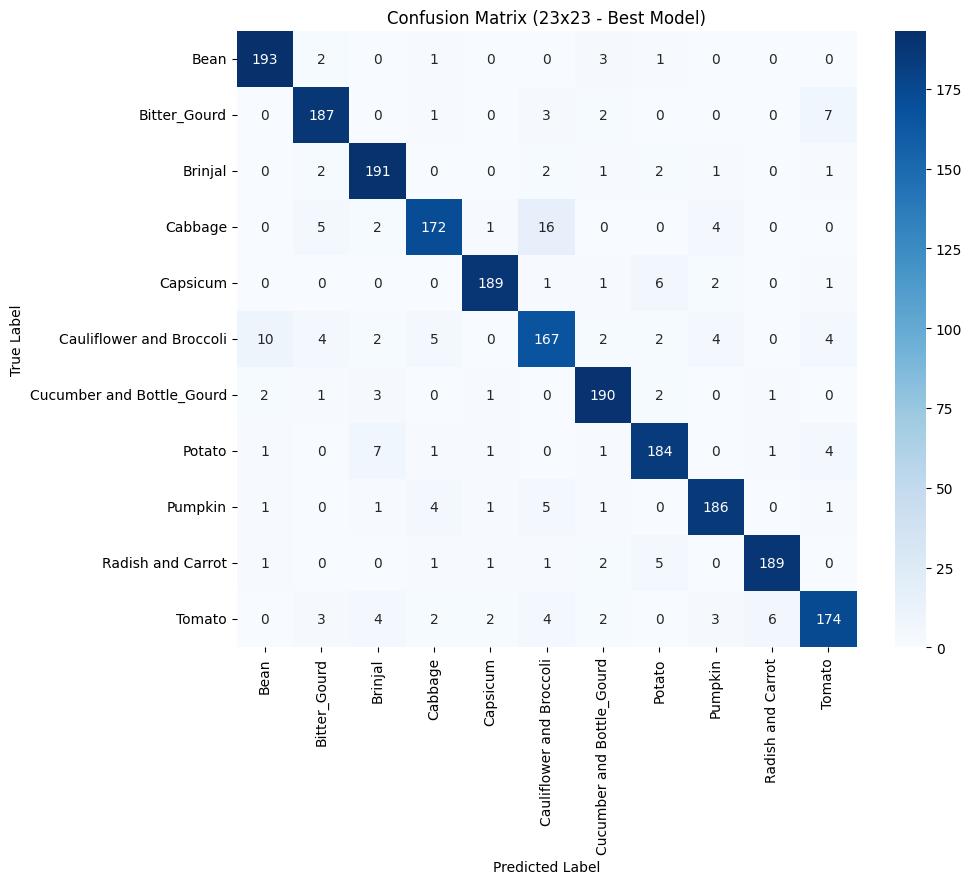

In [77]:
# Model Evaluation (23x23 Grayscale - Best Model after random erasing)
loss_A, accuracy_A = best_model_23.evaluate(test_images_A, test_labels_A, verbose=0)
print(f"Test Loss (23x23): {loss_A:.4f}")
print(f"Test Accuracy (23x23): {accuracy_A:.4f}")

predictions_A = best_model_23.predict(test_images_A)
predicted_labels_A = np.argmax(predictions_A, axis=1)


print("\nClassification Report (23x23 - Best Model after random erasing):")
print(classification_report(test_labels_A, predicted_labels_A, target_names=class_names))

cm_A = confusion_matrix(test_labels_A, predicted_labels_A)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_A, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (23x23 - Best Model)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

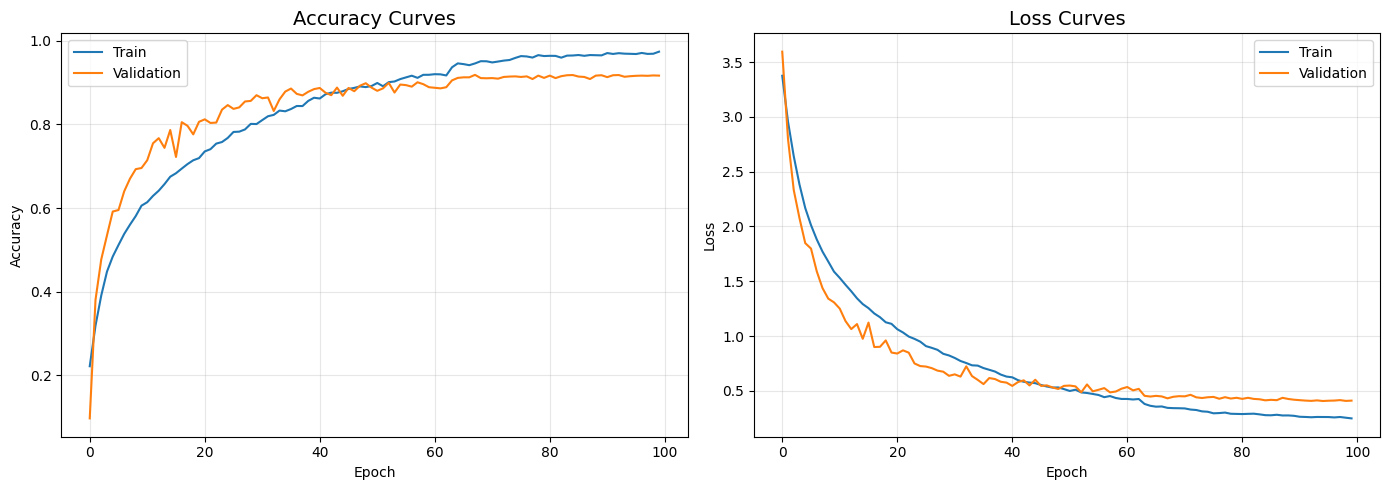

In [78]:
# plot training history
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history_23.history['accuracy'], label='Train')
plt.plot(history_23.history['val_accuracy'], label='Validation')
plt.title('Accuracy Curves', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history_23.history['loss'], label='Train')
plt.plot(history_23.history['val_loss'], label='Validation')
plt.title('Loss Curves', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

### Observation after retraining with random erasing
- After using the function random erasing on the train dataset, we can see that it has the performance has slightly improved
- We can assume that the model potentially overfitting to specific aspects of the training data
- We have solved the issue that our model was not robust enough to handle variations or occlusions

### save best weights for 23 by 23

In [79]:
# best weights saved (23x23)
if best_model_23 is not None:
    best_model_23.save_weights('model_A_best_weights_23x23.h5')
    print("\nBest Model (23x23) weights saved successfully!")
else:
    print("\nNo model weights saved.")


Best Model (23x23) weights saved successfully!


# Training the 101 x 101 model

## Loading the data to IMG_SIZE_B

In [59]:
# data Loading and Preprocessing for 101 by 101 
IMG_SIZE_B = (101, 101)

In [30]:
# load training data
train_images_B = []
train_labels_B = []
train_path_B = DATASET_DIR / 'Train'
for i, class_name in enumerate(class_names):
    class_path = train_path_B / class_name
    if class_path.exists():
        for image_path in class_path.glob('*'):
            if image_path.suffix.lower() not in ['.jpg', '.jpeg', '.png']:
                continue    
            image = tf.io.read_file(str(image_path))
            image = tf.image.decode_jpeg(image, channels=3)
            image = tf.image.rgb_to_grayscale(image)
            image = tf.image.resize(image, IMG_SIZE_B)
            image = tf.cast(image, tf.float32) / 255.0
            train_images_B.append(image)
            train_labels_B.append(i)
train_images_B = np.array(train_images_B)
train_labels_B = np.array(train_labels_B)


In [60]:
# load validation data
validation_images_B = []
validation_labels_B = []
validation_path_B = DATASET_DIR / 'Validation'
for i, class_name in enumerate(class_names):
    class_path = validation_path_B / class_name
    if class_path.exists():
        for image_path in class_path.glob('*'):
            if image_path.suffix.lower() not in ['.jpg', '.jpeg', '.png']:
                continue     
            image = tf.io.read_file(str(image_path))
            image = tf.image.decode_jpeg(image, channels=3)
            image = tf.image.rgb_to_grayscale(image)
            image = tf.image.resize(image, IMG_SIZE_B)
            image = tf.cast(image, tf.float32) / 255.0
            validation_images_B.append(image)
            validation_labels_B.append(i)
validation_images_B = np.array(validation_images_B)
validation_labels_B = np.array(validation_labels_B)

In [61]:
# load test data
test_images_B = []
test_labels_B = []
test_path_B = DATASET_DIR / 'Test'
for i, class_name in enumerate(class_names):
    class_path = test_path_B / class_name
    if class_path.exists():
        for image_path in class_path.glob('*'):
            if image_path.suffix.lower() not in ['.jpg', '.jpeg', '.png']:
                continue
            image = tf.io.read_file(str(image_path))
            image = tf.image.decode_jpeg(image, channels=3)
            image = tf.image.rgb_to_grayscale(image)
            image = tf.image.resize(image, IMG_SIZE_B)
            image = tf.cast(image, tf.float32) / 255.0
            test_images_B.append(image)
            test_labels_B.append(i)
test_images_B = np.array(test_images_B)
test_labels_B = np.array(test_labels_B)

## displaying the grayscaled images and reduced to 101 by 101 pixels

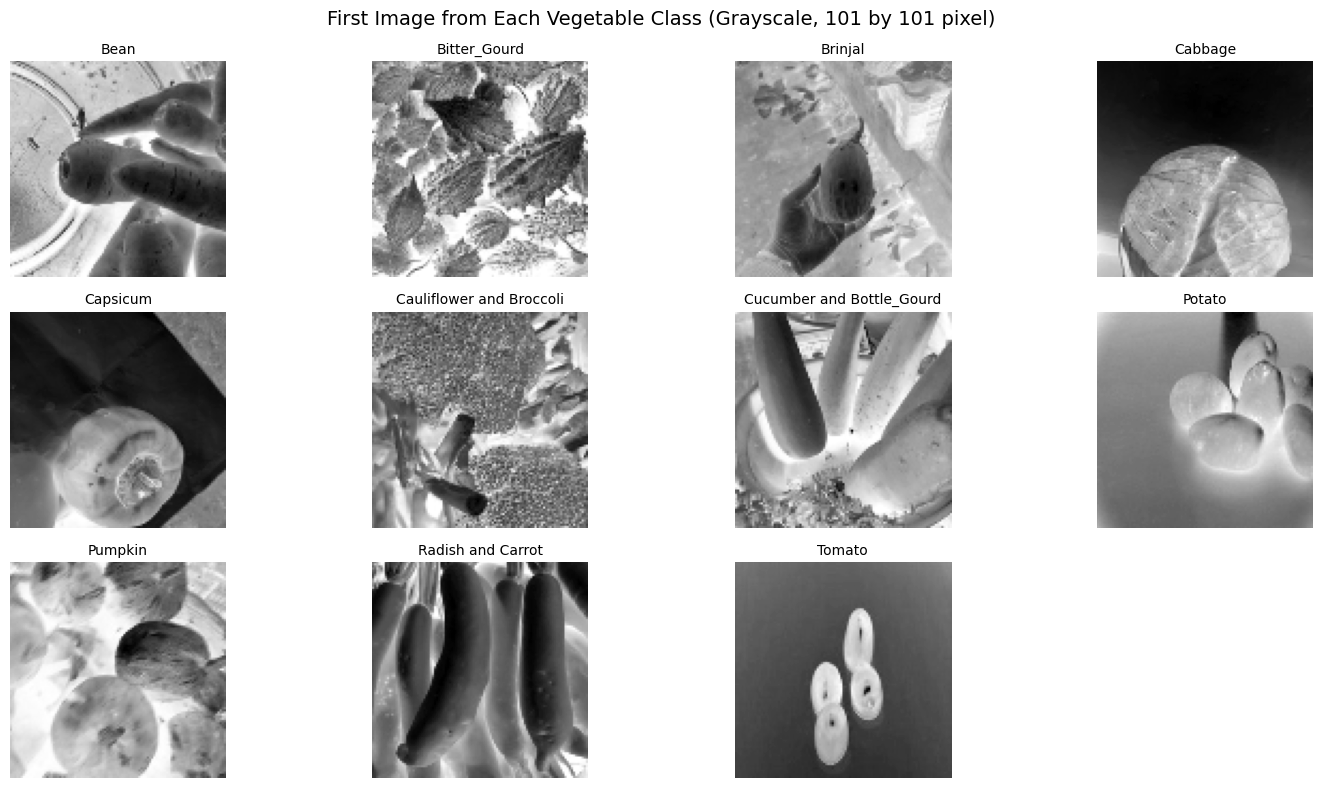

In [28]:
plt.figure(figsize=(15, 8))
for i, class_name in enumerate(class_names):
    # Find first image belonging to this class
    idx = np.where(train_labels_B == i)[0][0]
    img = train_images_B[idx].squeeze()
    
    plt.subplot(3, (len(class_names)+2)//3, i+1)
    plt.imshow(img, cmap=plt.cm.binary)
    plt.title(class_name, fontsize=10)
    plt.axis('off')

plt.suptitle("First Image from Each Vegetable Class (Grayscale, 101 by 101 pixel)", fontsize=14)
plt.tight_layout()
plt.show()


## Initial model building for 101 by 101

In [79]:
# build initial model
model_B = keras.Sequential([
    keras.Input(shape=(101, 101, 1)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])


In [80]:
# model compilation
model_B.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [81]:
# model training
history_B = model_B.fit(train_images_B, train_labels_B, epochs=20, validation_data=(validation_images_B, validation_labels_B))


Epoch 1/20
328/328 [==============================] - 7s 16ms/step - loss: 2.2746 - accuracy: 0.2313 - val_loss: 2.1435 - val_accuracy: 0.3332
Epoch 2/20
328/328 [==============================] - 5s 15ms/step - loss: 2.0892 - accuracy: 0.3251 - val_loss: 2.0293 - val_accuracy: 0.3386
Epoch 3/20
328/328 [==============================] - 5s 15ms/step - loss: 2.0011 - accuracy: 0.3552 - val_loss: 1.9574 - val_accuracy: 0.3855
Epoch 4/20
328/328 [==============================] - 5s 14ms/step - loss: 1.9363 - accuracy: 0.3864 - val_loss: 1.8976 - val_accuracy: 0.4150
Epoch 5/20
328/328 [==============================] - 5s 15ms/step - loss: 1.8762 - accuracy: 0.4127 - val_loss: 1.8329 - val_accuracy: 0.4236
Epoch 6/20
328/328 [==============================] - 5s 15ms/step - loss: 1.8198 - accuracy: 0.4342 - val_loss: 1.7955 - val_accuracy: 0.4445
Epoch 7/20
328/328 [==============================] - 5s 16ms/step - loss: 1.7693 - accuracy: 0.4507 - val_loss: 1.7352 - val_accuracy: 0.4741

Test Loss (101x1101): 1.4289
Test Accuracy (101x101): 0.5450
69/69 [==============================] - 1s 5ms/step

Classification Report (101x101):
                           precision    recall  f1-score   support

                     Bean       0.42      0.20      0.27       200
             Bitter_Gourd       0.63      0.75      0.68       200
                  Brinjal       0.55      0.49      0.52       200
                  Cabbage       0.60      0.48      0.53       200
                 Capsicum       0.56      0.84      0.67       200
 Cauliflower and Broccoli       0.33      0.40      0.36       200
Cucumber and Bottle_Gourd       0.60      0.59      0.59       200
                   Potato       0.52      0.53      0.52       200
                  Pumpkin       0.74      0.55      0.63       200
        Radish and Carrot       0.58      0.53      0.55       200
                   Tomato       0.50      0.65      0.57       200

                 accuracy                     

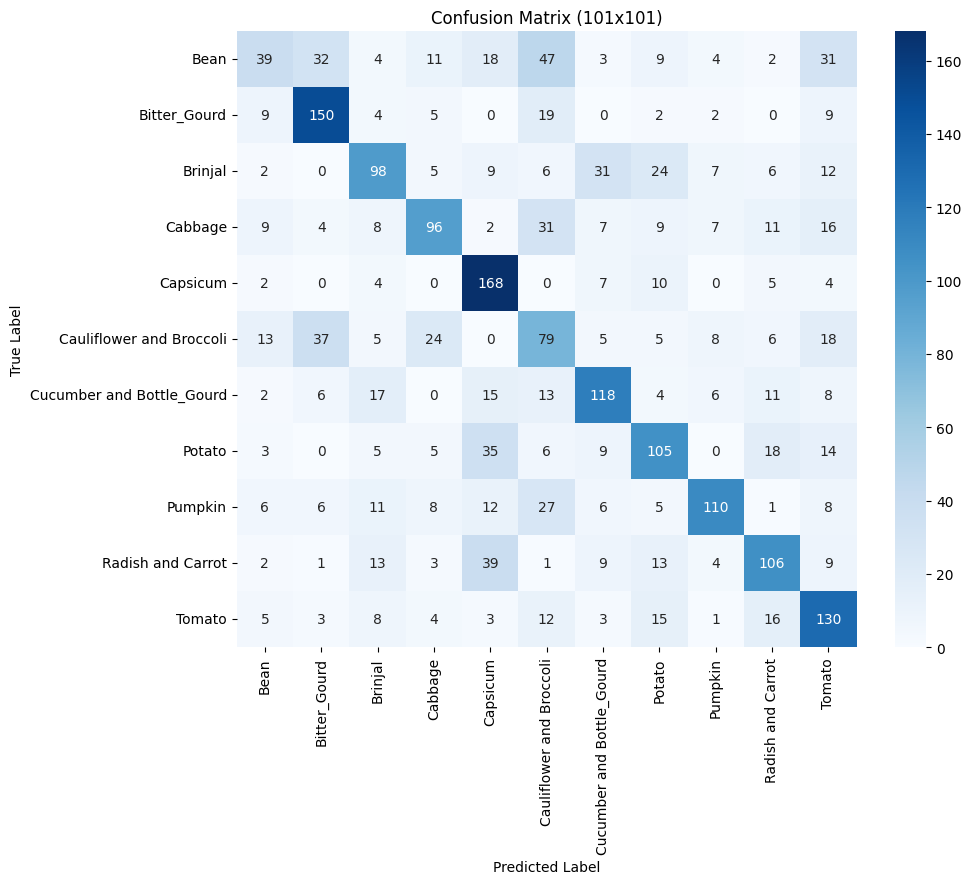

In [82]:
# model evaluation
loss_B, accuracy_B = model_B.evaluate(test_images_B, test_labels_B, verbose=0)
print(f"Test Loss (101x1101): {loss_B:.4f}")
print(f"Test Accuracy (101x101): {accuracy_B:.4f}")

predictions_B = model_B.predict(test_images_B)
predicted_labels_B = np.argmax(predictions_B, axis=1)

print("\nClassification Report (101x101):")
print(classification_report(test_labels_B, predicted_labels_B, target_names=class_names))

cm_B = confusion_matrix(test_labels_B, predicted_labels_B)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_B, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (101x101)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

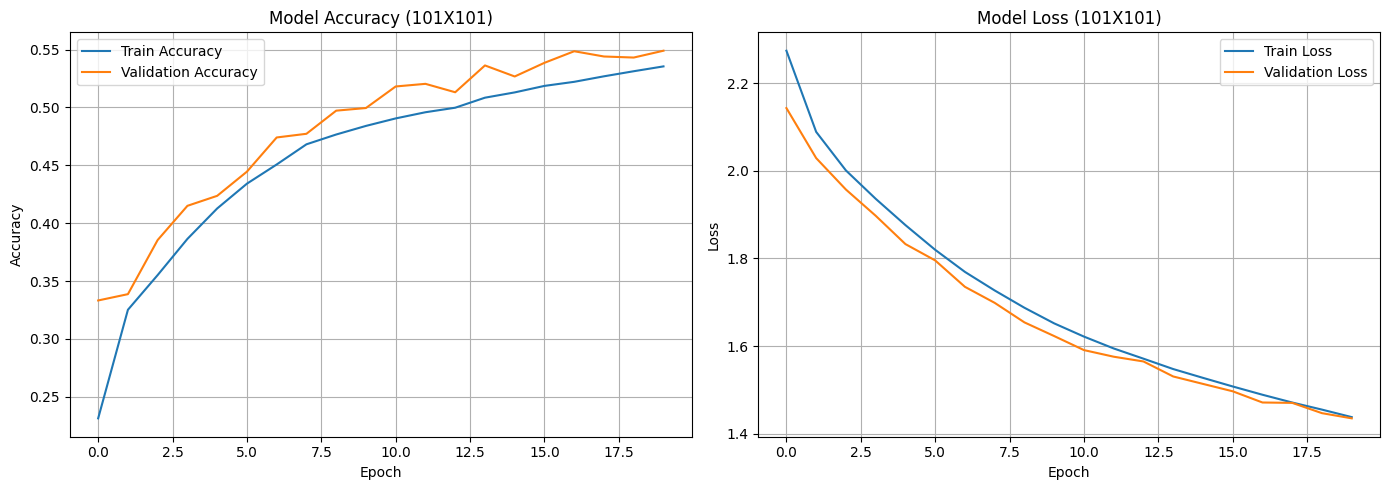

In [83]:
plt.figure(figsize=(14, 5))

# Accuracy history plot
plt.subplot(1, 2, 1)
plt.plot(history_B.history['accuracy'], label='Train Accuracy')
plt.plot(history_B.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy (101X101)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss history plot
plt.subplot(1, 2, 2)
plt.plot(history_B.history['loss'], label='Train Loss')
plt.plot(history_B.history['val_loss'], label='Validation Loss')
plt.title('Model Loss (101X101)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## Hyperparamter tuning for 101 by 101

In [92]:
# define hyperparameters
conv_filters = [16, 32]
dense_units = [32, 64]
dropouts = [0.1, 0.2, 0.3]
batch_sizes = [16, 32, 64] 
learning_rates = [1e-4, 1e-5]  

best_val_acc_101 = 0.0
best_model_101 = None
best_config_101 = {}
all_histories = []

In [93]:
for f in conv_filters:
    for d in dense_units:
        for do in dropouts:
            for bs in batch_sizes:
                for lr in learning_rates:
                    print(f'\nConv_filters: {f}, Dense_units: {d}, Dropout: {do}, Batch_size: {bs}, Learning Rate: {lr}')

                    model_101 = keras.Sequential([
                        keras.Input(shape=(101, 101, 1)),
                        layers.Conv2D(f, (3, 3), activation='relu', padding='same', kernel_regularizer='l2'),
                        layers.BatchNormalization(),
                        layers.MaxPooling2D((2, 2)),
                        layers.Dropout(do),
                        layers.Conv2D(f * 2 , (3, 3), activation='relu', padding='same', kernel_regularizer='l2'),
                        layers.BatchNormalization(),
                        layers.MaxPooling2D((2, 2)),
                        layers.Dropout(do),
                        layers.Conv2D(f * 4, (3, 3), activation='relu', padding='same', kernel_regularizer='l2'),
                        layers.BatchNormalization(),
                        layers.MaxPooling2D((2, 2)),
                        layers.Dropout(do),
                        layers.Conv2D(f * 6, (3, 3), activation='relu', padding='same', kernel_regularizer='l2'),
                        layers.BatchNormalization(),
                        layers.GlobalAveragePooling2D(),
                        layers.Dense(d, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2)),
                        layers.Dropout(do),
                        layers.Dense(num_classes, activation='softmax')
                    ])

                    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
                    model_101.compile(optimizer=optimizer,
                                  loss='sparse_categorical_crossentropy',
                                  metrics=['accuracy'])

                    # Implement Early Stopping
                    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True) 
                    history_101 = model_101.fit(train_images_B, train_labels_B, epochs=100, batch_size=64, validation_data=(validation_images_B, validation_labels_A), verbose=0, callbacks=[early_stopping])
                    all_histories.append(history_101.history)

                    val_acc = history_101.history['val_accuracy'][-1]
                    print(f"Validation accuracy: {val_acc:.4f}\n")

                    if val_acc > best_val_acc_101:
                        best_val_acc_101 = val_acc
                        best_model_101 = model_101
                        best_config_101 = {'conv_filters': f, 'dense_units': d, 'dropout': do, 'batch_size': bs, 'learning_rate': lr}


print("\nBest Validation Accuracy:", best_val_acc_101)
print("Best Configurations:", best_config_101)


Conv_filters: 16, Dense_units: 32, Dropout: 0.1, Batch_size: 16, Learning Rate: 0.0001


NameError: name 'l2' is not defined

In [ ]:
# Model Evaluation (101x101 Grayscale - Best Model)
loss_B, accuracy_B = best_model_101.evaluate(test_images_B, test_labels_B, verbose=0)
print(f"Test Loss (101x101): {loss_B:.4f}")
print(f"Test Accuracy (101x101): {accuracy_B:.4f}")

print("\nBest Model Parameters:")
# print(f"  Conv Filters: {best_config_101['conv_filters']}")
# print(f"  Dense Units: {best_config_101['dense_units']}")
# print(f"  Dropout: {best_config_101['dropout']:.2f}")
# print(f"  Batch Size: {best_config_101['batch_size']}")
# print(f"  Learning Rate: {best_config_101['learning_rate']:.5f}")

predictions_B = best_model_101.predict(test_images_B)
predicted_labels_B = np.argmax(predictions_B, axis=1)


print("\nClassification Report (101x101 - Best Model):")
print(classification_report(test_labels_B, predicted_labels_B, target_names=class_names))

cm_B = confusion_matrix(test_labels_B, predicted_labels_B)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_B, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (101x101 - Best Model)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
# plot training history
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history_101.history['accuracy'], label='Train')
plt.plot(history_101.history['val_accuracy'], label='Validation')
plt.title('Accuracy Curves', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history_101.history['loss'], label='Train')
plt.plot(history_101.history['val_loss'], label='Validation')
plt.title('Loss Curves', fontsize=14)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

### Observations during hyperparams tuning (101x101):
- after tuning, we have improved significantly in test accuracy
- our training history is extremely jumpy and does not generalize well,indicating underfitting AND overfitting
- even after making huge dropouts we still have not solved our overfitting issue.
- by increasing layers and making the model more complex we have solved our underfitting problem but our overfitting issue remains
- increasing conv_filters gradually solves the overfitting issue but slightly, the model is still generalizing not as well as expected

## Manual tuning for 101 by 101

In [94]:
best_val_acc_101 = 0.0
best_model_101 = None
best_config_101 = {}
all_histories = []

In [95]:
model_101 = keras.Sequential([
    keras.Input(shape=(101, 101, 1)),
    layers.Conv2D(16, (3, 3), activation='relu', padding='same', kernel_regularizer='l2'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.1),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer='l2'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.1),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer='l2'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.1),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer='l2'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    layers.Conv2D(16, (3, 3), activation='relu', padding='same', kernel_regularizer='l2'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.1),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer='l2'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.1),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer='l2'),
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),
    layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model_101.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Implement Early Stopping
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=5,verbose=1, min_lr=1e-7)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True) 
history_101 = model_101.fit(
    train_images_B, train_labels_B,
    epochs=100,
    batch_size=64,
    validation_data=(validation_images_B, validation_labels_B),
    verbose=0,
    callbacks=[early_stopping, reduce_lr]
)
all_histories.append(history_101.history)

val_acc = history_101.history['val_accuracy'][-1]
print(f"Validation accuracy: {val_acc:.4f}\n")

if val_acc > best_val_acc_101:
    best_val_acc_101 = val_acc
    best_model_101 = model_101
    #best_config_101 = {'conv_filters': f, 'dense_units': d, 'dropout': do, 'batch_size': bs, 'learning_rate': lr}


print("\nBest Validation Accuracy:", best_val_acc_101)
print("Best Configurations:", best_config_101)


Epoch 52: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 62: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 67: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
Validation accuracy: 0.8309


Best Validation Accuracy: 0.8309090733528137
Best Configurations: {}


Test Loss (101x101): 0.9570
Test Accuracy (101x101): 0.8677

Best Model Parameters:
69/69 [==============================] - 1s 8ms/step

Classification Report (101x101 - Best Model):
                           precision    recall  f1-score   support

                     Bean       0.80      0.89      0.84       200
             Bitter_Gourd       0.84      0.86      0.85       200
                  Brinjal       0.91      0.91      0.91       200
                  Cabbage       0.83      0.85      0.84       200
                 Capsicum       0.97      0.92      0.94       200
 Cauliflower and Broccoli       0.84      0.83      0.83       200
Cucumber and Bottle_Gourd       0.79      0.96      0.87       200
                   Potato       0.81      0.90      0.85       200
                  Pumpkin       0.94      0.93      0.93       200
        Radish and Carrot       0.91      0.78      0.84       200
                   Tomato       0.98      0.72      0.83       200

          

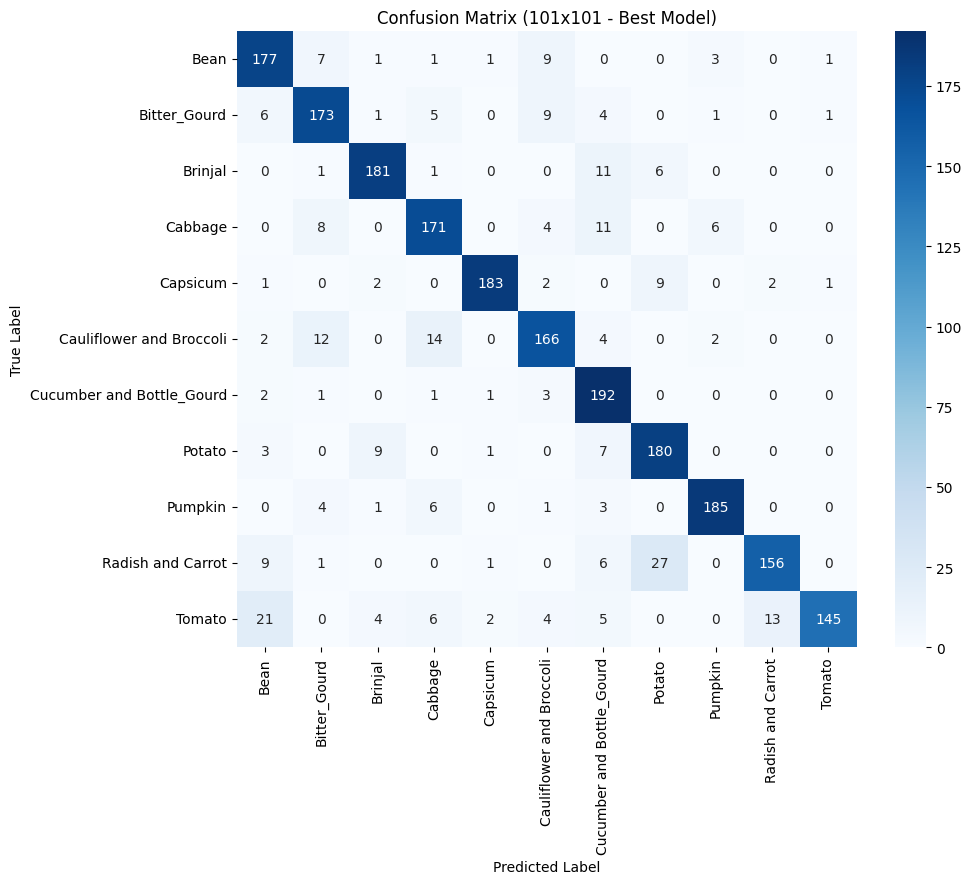

In [96]:
# Model Evaluation (101x101 Grayscale - Best Model)
loss_B, accuracy_B = best_model_101.evaluate(test_images_B, test_labels_B, verbose=0)
print(f"Test Loss (101x101): {loss_B:.4f}")
print(f"Test Accuracy (101x101): {accuracy_B:.4f}")

print("\nBest Model Parameters:")
# print(f"  Conv Filters: {best_config_101['conv_filters']}")
# print(f"  Dense Units: {best_config_101['dense_units']}")
# print(f"  Dropout: {best_config_101['dropout']:.2f}")
# print(f"  Batch Size: {best_config_101['batch_size']}")
# print(f"  Learning Rate: {best_config_101['learning_rate']:.5f}")

predictions_B = best_model_101.predict(test_images_B)
predicted_labels_B = np.argmax(predictions_B, axis=1)


print("\nClassification Report (101x101 - Best Model):")
print(classification_report(test_labels_B, predicted_labels_B, target_names=class_names))

cm_B = confusion_matrix(test_labels_B, predicted_labels_B)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_B, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (101x101 - Best Model)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

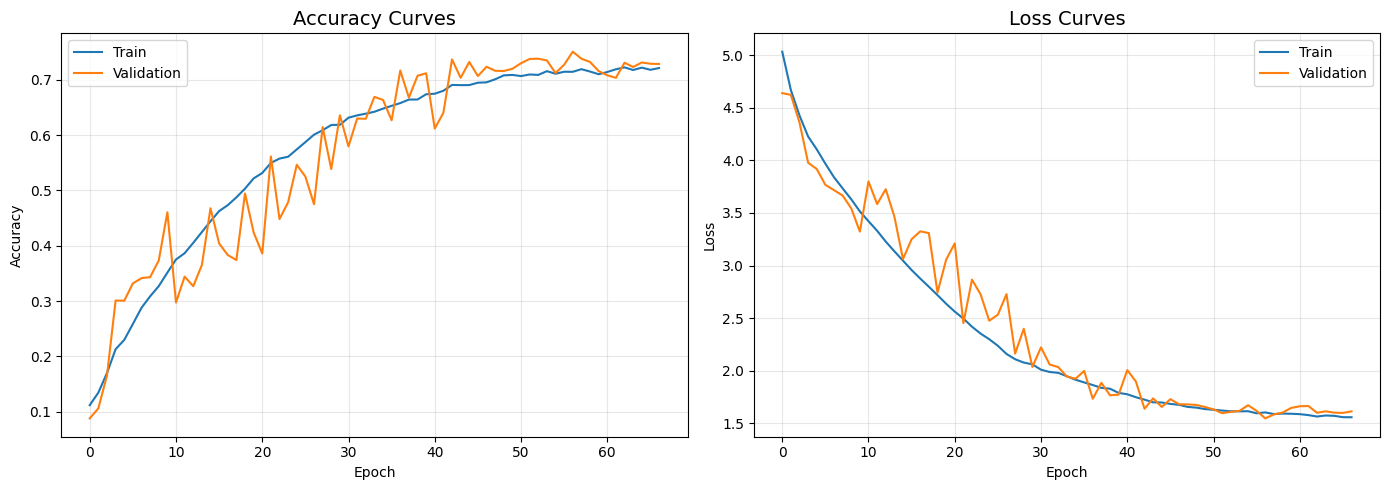

In [91]:
# plot training history
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history_101.history['accuracy'], label='Train')
plt.plot(history_101.history['val_accuracy'], label='Validation')
plt.title('Accuracy Curves', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history_101.history['loss'], label='Train')
plt.plot(history_101.history['val_loss'], label='Validation')
plt.title('Loss Curves', fontsize=14)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Retrain using random erasing for 101 by 101

In [62]:
# Load training data again but with random erasing function
train_images_B = []
train_labels_B = []
train_path_B = DATASET_DIR / 'Train'
for i, class_name in enumerate(class_names):
    class_path = train_path_B / class_name
    for image_path in class_path.glob('*'):
        if image_path.suffix.lower() not in ['.jpg', '.jpeg', '.png']:
            continue
        image = tf.io.read_file(str(image_path))
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.rgb_to_grayscale(image)
        image = tf.image.resize(image, IMG_SIZE_B)
        image = tf.cast(image, tf.float32) / 255.0
        
        # Apply Random Erasing ONLY to training images
        image = random_erasing(image)
        
        train_images_B.append(image)
        train_labels_B.append(i)
train_images_B = np.array(train_images_B)
train_labels_B = np.array(train_labels_B)

In [63]:
best_val_acc_101 = 0.0
best_model_101 = None
best_config_101 = {}
all_histories = []

In [64]:
model_101 = keras.Sequential([
    keras.Input(shape=(101, 101, 1)),
    layers.Conv2D(16, (3, 3), activation='relu', padding='same', kernel_regularizer='l2'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer='l2'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer='l2'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer='l2'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer='l2'),
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),
    layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model_101.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Implement Early Stopping
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=5,verbose=1, min_lr=1e-7)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True) 
history_101 = model_101.fit(
    train_images_B, train_labels_B,
    epochs=100,
    batch_size=64,
    validation_data=(validation_images_B, validation_labels_B),
    verbose=0,
    callbacks=[early_stopping, reduce_lr]
)
all_histories.append(history_101.history)

val_acc = history_101.history['val_accuracy'][-1]
print(f"Validation accuracy: {val_acc:.4f}\n")

if val_acc > best_val_acc_101:
    best_val_acc_101 = val_acc
    best_model_101 = model_101
    #best_config_101 = {'conv_filters': f, 'dense_units': d, 'dropout': do, 'batch_size': bs, 'learning_rate': lr}


print("\nBest Validation Accuracy:", best_val_acc_101)
print("Best Configurations:", best_config_101)


Epoch 17: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 26: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 31: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
Validation accuracy: 0.5709


Best Validation Accuracy: 0.5709090828895569
Best Configurations: {}


Test Loss (101x101): 2.0052
Test Accuracy (101x101): 0.5614

Best Model Parameters:
69/69 [==============================] - 1s 10ms/step

Classification Report (101x101 - Best Model):
                           precision    recall  f1-score   support

                     Bean       0.39      0.70      0.50       200
             Bitter_Gourd       0.43      0.87      0.58       200
                  Brinjal       0.93      0.38      0.53       200
                  Cabbage       0.43      0.78      0.56       200
                 Capsicum       0.97      0.43      0.60       200
 Cauliflower and Broccoli       0.38      0.66      0.48       200
Cucumber and Bottle_Gourd       0.91      0.39      0.55       200
                   Potato       0.86      0.36      0.51       200
                  Pumpkin       0.80      0.60      0.69       200
        Radish and Carrot       0.82      0.69      0.75       200
                   Tomato       0.97      0.30      0.46       200

         

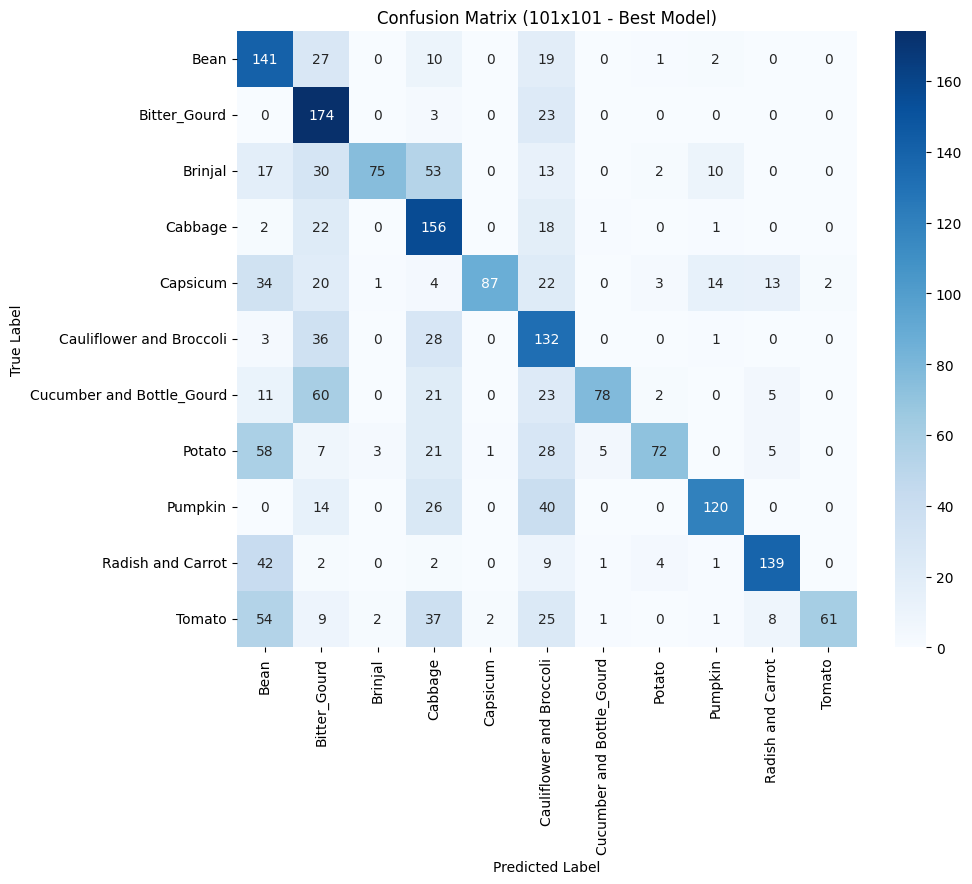

In [65]:
# Model Evaluation (101x101 Grayscale - Best Model)
loss_B, accuracy_B = best_model_101.evaluate(test_images_B, test_labels_B, verbose=0)
print(f"Test Loss (101x101): {loss_B:.4f}")
print(f"Test Accuracy (101x101): {accuracy_B:.4f}")

print("\nBest Model Parameters:")
# print(f"  Conv Filters: {best_config_101['conv_filters']}")
# print(f"  Dense Units: {best_config_101['dense_units']}")
# print(f"  Dropout: {best_config_101['dropout']:.2f}")
# print(f"  Batch Size: {best_config_101['batch_size']}")
# print(f"  Learning Rate: {best_config_101['learning_rate']:.5f}")

predictions_B = best_model_101.predict(test_images_B)
predicted_labels_B = np.argmax(predictions_B, axis=1)


print("\nClassification Report (101x101 - Best Model):")
print(classification_report(test_labels_B, predicted_labels_B, target_names=class_names))

cm_B = confusion_matrix(test_labels_B, predicted_labels_B)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_B, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (101x101 - Best Model)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

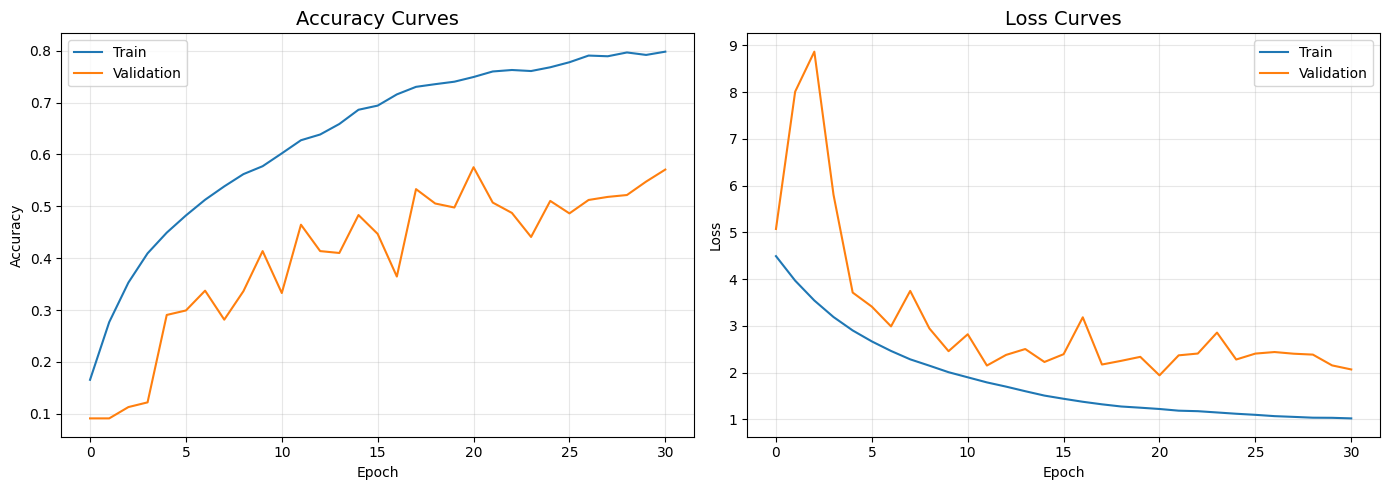

In [66]:
# plot training history
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history_101.history['accuracy'], label='Train')
plt.plot(history_101.history['val_accuracy'], label='Validation')
plt.title('Accuracy Curves', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history_101.history['loss'], label='Train')
plt.plot(history_101.history['val_loss'], label='Validation')
plt.title('Loss Curves', fontsize=14)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Observations after retraining with random erasing for 101 by 101
- Our model's performance significantly decreased after applying random erasing
- This might indicate that the data augmentation technique is not suitable for the specific model or the dataset. As evident from the horrendous performance
- This could have been caused by our model's complexity, due to how many layers we have, we could have amplified its weakness and decreased our 101 by 101 model's performance significantly

### save weights

In [ ]:
# best weights saved (101x101)
if best_model_101 is not None:
    best_model_101.save_weights('model_B_best_weights_101x101.h5')
    print("\nBest Model (101x101) weights saved successfully!")
else:
    print("\nNo model weights saved.")